# Brainwave analysis (reading vs writing state)
<i>October 1, 2018</i><br>
Viacheslav Nesterov

In [1]:
# Imports
import sys
import os
import numpy as np
import pandas as pd
import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from numpy import argmax
import seaborn as sns

from imp import reload
import utils
reload(utils)
from utils import*

import matplotlib.pyplot as plt
%matplotlib inline

# path
path = 'SavedData/data_r_w/'
path_r = 'SavedData/data_r_w/reading/'
path_w = 'SavedData/data_r_w/writing/'

Using TensorFlow backend.


#### On further sample example the key preprocessing steps will be demonstrated

It is necessary to get 8 channels data from <a href='http://docs.openbci.com/Hardware/03-Cyton_Data_Format#cyton-data-format-interpreting-the-eeg-data'>EEG recorded data</a>.<br>
Raw datafile contains a little bit more:

In [2]:
# sample data from headset (EEG)
sample = pd.read_csv(path+'sample.txt', sep=",", header=None)

In [3]:
sample[:5]

0         1         2         3         4         5        6         7   \
0  185  58618.86  53523.57 -30090.90 -35064.43 -23330.84 -8979.72 -20677.42   
1  186  56983.38  53428.82 -31389.02 -35162.67 -23361.28 -8974.02 -20932.99   
2  187  54007.64  53505.58 -34059.57 -36148.29 -23147.31 -8638.86 -22330.82   
3  188  52158.42  53686.63 -35635.79 -36097.86 -22749.87 -8340.93 -22689.63   
4  189  51213.07  53778.96 -36408.46 -35831.50 -22692.63 -8360.49 -22636.42   

        8    9    10   11             12  
0 -5400.47  0.0  0.0  0.0   21:34:27.470  
1 -5383.91  0.0  0.0  0.0   21:34:27.471  
2 -5117.63  0.0  0.0  0.0   21:34:27.471  
3 -4718.21  0.0  0.0  0.0   21:34:27.471  
4 -4754.48  0.0  0.0  0.0   21:34:27.471

All that we need from here are columns 1 - 8 that are our corresponding channels (obtained data from respective electrodes 1 - 8).
We also need column 12 that will help us to collect data for each second.<br>
Data logged and recorded in high resolution with 1000 Hz sample rate. Ideally each row of data represents 1/1000 fraction of data point sample for 1 second. Another words we have 1000 samples or impulses recorded per 1 second. However, due to equipment specific some data cycles/impulses may deviate from desirable rate and we may receive unequal number of impulses per second rather than 1000. Therefore, the goal is to compile each sample of data input consisting of equal number of impulses for 1 second.<br>
So, with that we need to balance the data and get each sample of training data to be equal. It was decided to equalize each sample of data to have 990 rows (recorded impulses). Seconds which will have different number of impulses will be cut off.<br>
Below is depiction of the case on example extract from dataset.

In [4]:
# seting up second's impulses 'duration /length'
dur = 990

In [5]:
# making basic preprocessing - removing unnecessary columns and changing time column '12' to have format hh:mm:ss
sample = dip_drop(sample)
sample = basics(sample)

(47738, 9)
Realigned time column


In [6]:
sample[:3]

1         2         3         4         5        6         7  \
0  58618.86  53523.57 -30090.90 -35064.43 -23330.84 -8979.72 -20677.42   
1  56983.38  53428.82 -31389.02 -35162.67 -23361.28 -8974.02 -20932.99   
2  54007.64  53505.58 -34059.57 -36148.29 -23147.31 -8638.86 -22330.82   

         8       sec  
0 -5400.47  21:34:27  
1 -5383.91  21:34:27  
2 -5117.63  21:34:27

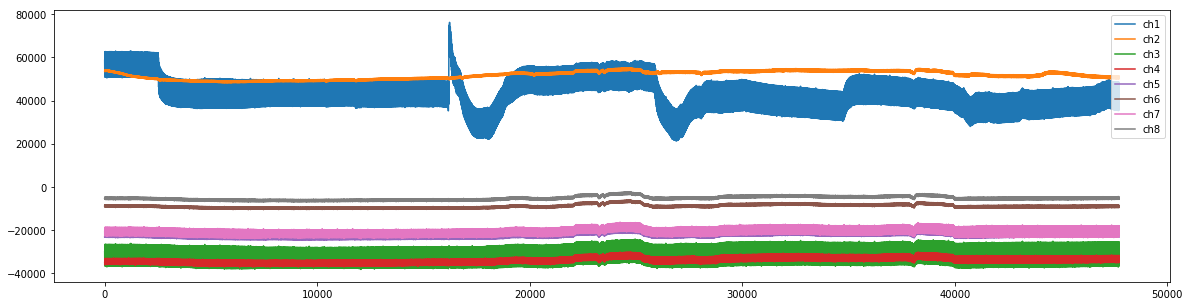

In [7]:
# this is how our sample data looks
# x axis represents time horizon - impulses per second. 1000 impulses comprisess 1 second.
d_plot(sample)

In [8]:
# looking at each seconds' impulses (intervals)
balance_check(sample[:int(len(sample)/6)], dur)

Seconds are not equal!
['21:34:27' '529']
Seconds are not equal!
['21:34:28' '1001']
Seconds are not equal!
['21:34:29' '999']
Seconds are not equal!
['21:34:30' '995']
Seconds are not equal!
['21:34:31' '1005']
Seconds are not equal!
['21:34:32' '993']
Seconds are not equal!
['21:34:33' '1007']
Seconds are not equal!
['21:34:34' '993']
Seconds are not equal!
['21:34:35' '434']
Check completed for balanced intervals!


True

As it seen from above, each second has different number of impulses.<br>
On this example below we balance sample data to get equal 990 impulses per second.

In [9]:
sample = balance_intervals(sample, dur)
balance_check(sample, dur)

Check completed for balanced intervals!


True

In [10]:
sec_disp(sample)[:5]

array([['21:34:28', '990'],
       ['21:34:29', '990'],
       ['21:34:30', '990'],
       ['21:34:31', '990'],
       ['21:34:32', '990']],
      dtype='<U8')

Going further, we know that we cant just load data to the model without rescaling it. Just look <i>how variant is each channels voltage impulses</i>.

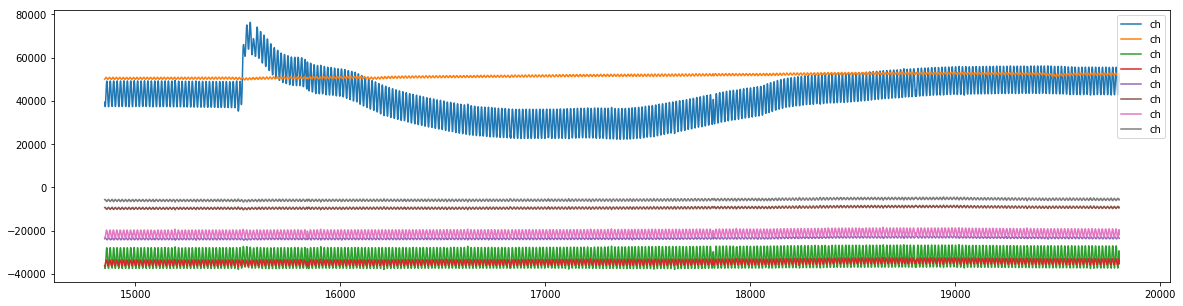

In [11]:
d_plot(sample, chan=[1,2,3,4,5,6,7,8], seconds=5, start=15, dur=dur)

So, we want further to rescale our data. But should we just take whole dataset and rescale it against itself? The answer is no. Because if we rescale wholistic dataset, which will be hundreds of seconds long, we will not be able make prediction on shorter datasets that represent couple of seconds.<br>
That’s why it was decided to rescale dataset by seconds' batches. Dedicated function will iterate through all dataset by batch of seconds and scale each batch separately and consecutively. The size of batch was defined given two goals:<br>
1) The most shorter interval to predict (mostly when using the model with live dataflow, when user can see what model predicts each 'x' number of seconds);<br>
2) Get highest model accuracy. Given the amount of training data and specifics of this project (see Dataset Specifics section above) it was challenging to pick right size of batch.<br>
Below the batch value is set.

In [12]:
######################
# seconds batch#######
secbatch = 10  #######
######################

To rescale the data is not enough for the nature of data of this project. Although data received was filtered, there are still spikes could be from muscle activity or other noise.<br>
To handle that it was decided to remove spikes on non-rescaled dataset first. Below variable sets up the margin above which the spike data will be cut off. It is important to note that spikes identification is coded to be measured within each second.

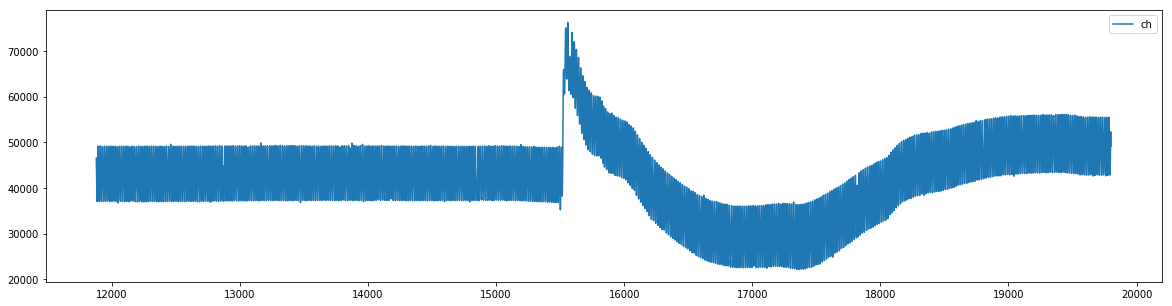

In [13]:
# this is how spike looks
d_plot(sample, chan=[1], seconds=8, start=12, dur=dur)

In [14]:
#####################################
# variance margin to trim the wave###
margin = 15000                    ###
#####################################

In [15]:
# removing spike (trimming)
sample = variance_clean(sample, margin)

Cleaned spikes larger than 15000


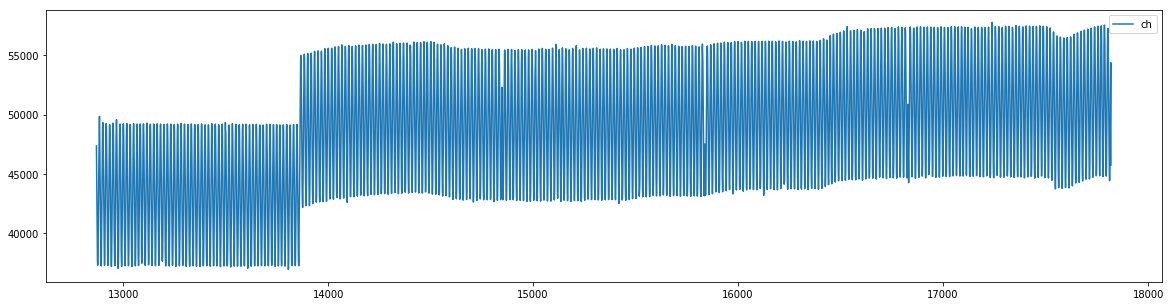

In [16]:
# this is how same piece looks after spike removed
d_plot(sample, chan=[1], seconds=5, start=13, dur=dur)

As it can be noticed, there is still shift where spike has been removed, however such slip has significantly less impact on data integrity. The 'variance_clean()' function used for trimming spike is quite simple and just trims the spike against measuring the whole wave diapason through one recorded dataset.<br>
It also noticeable that the length of our dataset (number of seconds we want to work with) decreases while we clean up the data. For this reason simple 'seconds()' function was used to monitor the remaining useful data left for training. In case we have 0 or to small amount of data the actions should be taken (dataset should have been regenerated in most of the cases).

In [17]:
# this function helps to see how many useful seconds left in dataset after cleanup.
seconds(sample)


Seconds in dataset now:  31


Now let’s come back to rescaling and see one of the most important functions for data preprocessing here -'scaler()'. With it help the dataset will be rescaled with equal seconds batches. Given the specifics of data it was decided to rescale in between 0 and 1.<br>
Before running scaler lets see how given example dataset looks like (after seconds balancing and spikes cleaning).

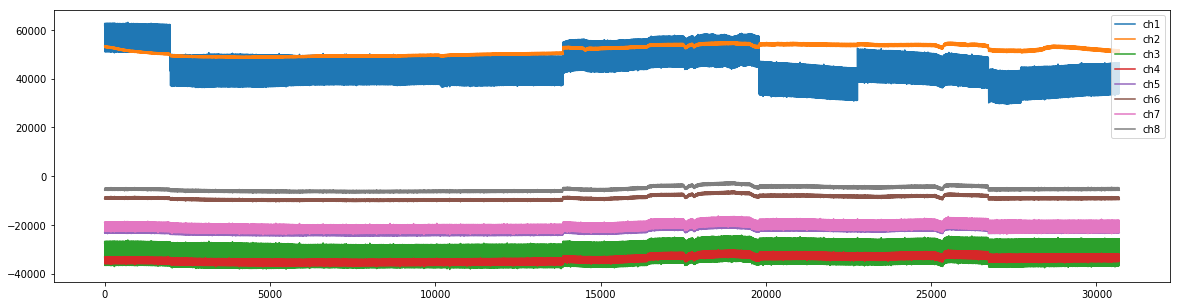

In [18]:
d_plot(sample)

In [19]:
# rescaling
sample = scaler(sample, secs=secbatch, dur=dur)


Seconds in dataset now:  30
Check completed for balanced intervals!
Dataset has been rescaled 



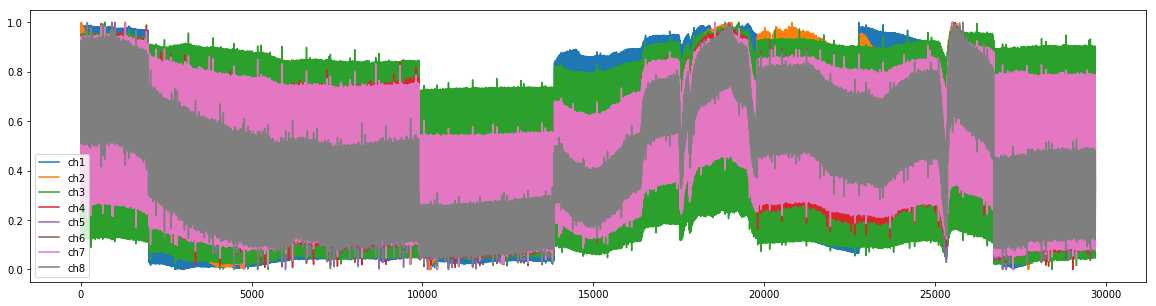

In [20]:
# rescaled data exaple - ready for model training
d_plot(sample)

Shifts may be noticeable on the chart above that looks like dataset is still skewed. However, this is acceptable as far as shifts' edges coincide with end of seconds. Another words 1 second contains 990 impulses that are individually measured subject to spikes. Let’s look at second around 15000 index.

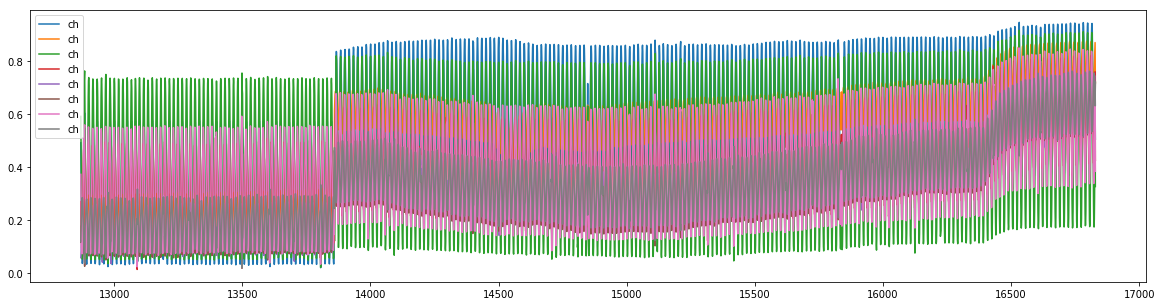

In [21]:
d_plot(sample, chan=[1,2,3,4,5,6,7,8], seconds=4, start=13, dur=dur)

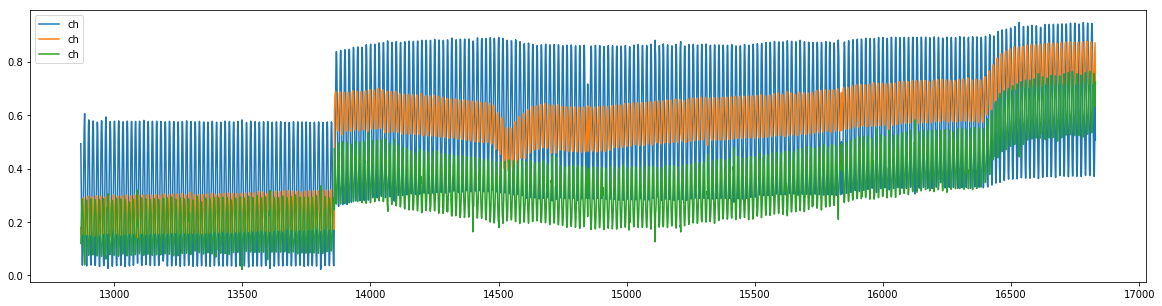

In [22]:
# look at few channels only
d_plot(sample, chan=[1,2,8], seconds=4, start=13, dur=dur)

Now lets preprocess training data.

#### Further code represents project work on data preprocessing, model preparation, training and testing.

## Previewing data

In [23]:
# reviewing files
print('reading files:')
for f in os.walk(path_r):
    for i in f[2]:
        if i.split('.')[1] == 'txt':
            print(i)
print('\nwriting files:')
for f in os.walk(path_w):
    for i in f[2]:
        if i.split('.')[1] == 'txt':
            print(i)

reading files:
OpenBCI-RAW-reading1.txt
OpenBCI-RAW-reading2.txt
OpenBCI-RAW-reading3.txt
OpenBCI-RAW-reading4.txt

writing files:
OpenBCI-RAW-writing1.txt
OpenBCI-RAW-writing3.txt
OpenBCI-RAW-writing2.txt


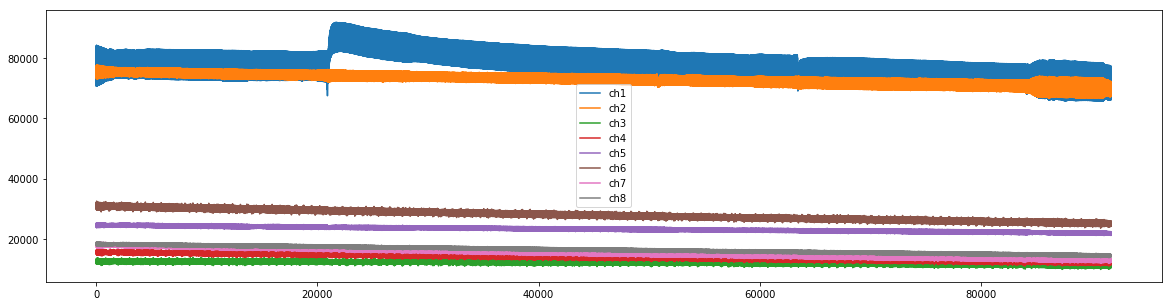

In [24]:
# looking up one of datasets for reading
data = pd.read_csv(path_r+'OpenBCI-RAW-reading1.txt', sep=",", header=None)
d_plot(data)

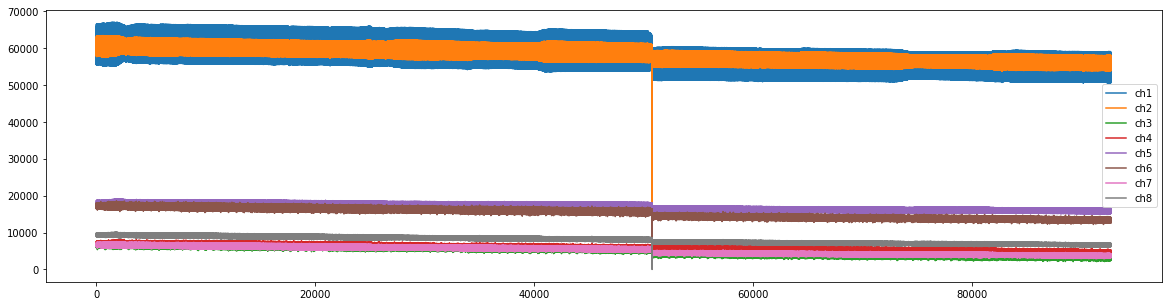

In [25]:
# looking up one of datasets for writing
data = pd.read_csv(path_w+'OpenBCI-RAW-writing1.txt', sep=",", header=None)
d_plot(data)

Dataset: OpenBCI-RAW-reading1.txt
(91771, 9)
Realigned time column
Dataset: OpenBCI-RAW-reading2.txt
(94408, 9)
Realigned time column
Dataset: OpenBCI-RAW-reading3.txt
(70368, 9)
Realigned time column
Dataset: OpenBCI-RAW-reading4.txt
(67839, 9)
Realigned time column
RAW Dataset parameters: shape (324386, 9); length 327 seconds.


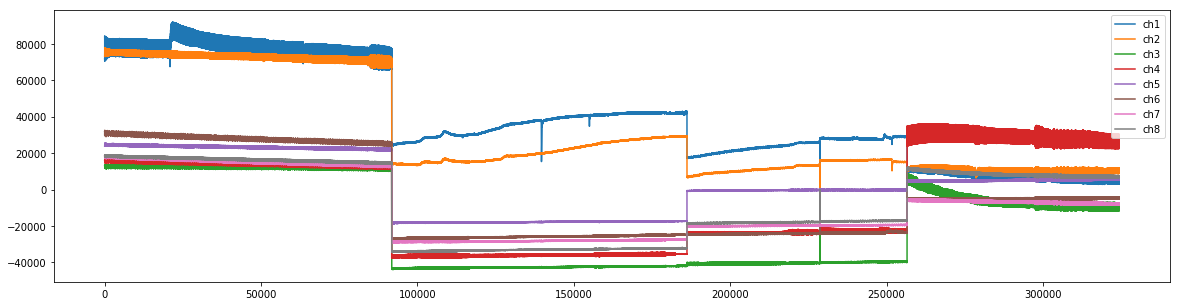

In [26]:
# vizualizing all datasets together without any cleaning
# iterating through directory to prepare each dataset and concatenate into one
# 'reading' dataset for vizualisation
sets = []
for f in os.walk(path_r):
    for i in f[2]:
        if i.split('.')[1] == 'txt':
            print("Dataset:", i)
            data = vizualize_prep(f[0]+i)
            sets.append(data)
vr_dat = pd.concat(sets)
vr_dat = vr_dat.reset_index(drop=True)
print("RAW Dataset parameters: shape {}; length {} seconds.".format(vr_dat.shape,
                                                                int(len(vr_dat['sec'])/dur)))
# plotting
d_plot(vr_dat)

Dataset: OpenBCI-RAW-writing1.txt
(92641, 9)
Realigned time column
Dataset: OpenBCI-RAW-writing3.txt
(130628, 9)
Realigned time column
Dataset: OpenBCI-RAW-writing2.txt
(71710, 9)
Realigned time column
RAW Dataset parameters: shape (294979, 9); length 297 seconds.


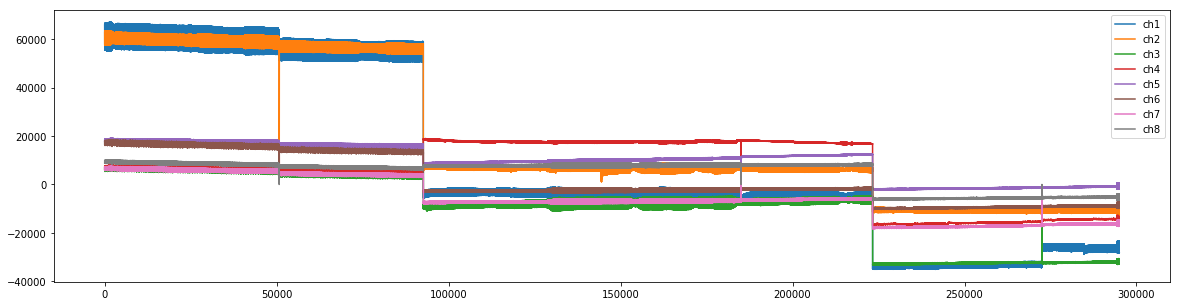

In [27]:
# vizualizing all datasets together without any cleaning
# iterating through directory to prepare each dataset and concatenate into one
# 'writing' dataset for vizualisation
sets = []
for f in os.walk(path_w):
    for i in f[2]:
        if i.split('.')[1] == 'txt':
            print("Dataset:", i)
            data = vizualize_prep(f[0]+i)
            sets.append(data)
vw_dat = pd.concat(sets)
vw_dat = vw_dat.reset_index(drop=True)
print("RAW Dataset parameters: shape {}; length {} seconds.".format(vw_dat.shape,
                                                                int(len(vw_dat['sec'])/dur)))
# plotting
d_plot(vw_dat)

## Loading and preprocessing data

In [28]:
# data preprocessing function
def preprocess(fl, dur=dur, var=margin, secbatch=secbatch):
    '''"fl" (fullpath) - Takes dataset file
    "dur" - length of second - number of items per second
    "var" - variance of wave that need to be trimmed
    "secbatch" - batch of seconds to scale
    Returns balanced preprocessed data'''
    # loading the data
    dset = pd.read_csv(fl, sep=",", header=None)
    # removing unnecessary columns
    dset = dip_drop(dset)
    # realigning timelapse column
    dset = basics(dset)
    # checking length
    seconds(dset)
    # cleaning spikes
    dset = variance_clean(dset, var)
    # checking length again
    seconds(dset)
    # balancing seconds intervals to have same length
    dset = balance_intervals(dset, dur)
    balance_check(dset, dur)
    # trimming and scaling to fit the integrity for data prep
    dset = scaler(dset, secbatch, dur)
    return dset

In [29]:
# iterating through directory to preprocess each dataset and concatenate into one
# 'reading' dataset
sets = []
for f in os.walk(path_r):
    for i in f[2]:
        if i.split('.')[1] == 'txt':
            print('Preprocessing:',i)
            data = preprocess(f[0]+i)
            sets.append(data)
r_dat = pd.concat(sets)
r_dat = r_dat.reset_index(drop=True)
print("Done preprocessing 'Reading' dataset")
print("Dataset parameters: shape {}; length {} seconds.".format(r_dat.shape,
                                                                len(r_dat['sec'])/dur))

Preprocessing: OpenBCI-RAW-reading1.txt
(91771, 9)
Realigned time column

Seconds in dataset now:  93
Cleaned spikes larger than 15000

Seconds in dataset now:  92
Check completed for balanced intervals!

Seconds in dataset now:  80
Check completed for balanced intervals!
Dataset has been rescaled 

Preprocessing: OpenBCI-RAW-reading2.txt
(94408, 9)
Realigned time column

Seconds in dataset now:  95
Cleaned spikes larger than 15000

Seconds in dataset now:  94
Check completed for balanced intervals!

Seconds in dataset now:  80
Check completed for balanced intervals!
Dataset has been rescaled 

Preprocessing: OpenBCI-RAW-reading3.txt
(70368, 9)
Realigned time column

Seconds in dataset now:  72
Cleaned spikes larger than 15000

Seconds in dataset now:  71
Check completed for balanced intervals!

Seconds in dataset now:  60
Check completed for balanced intervals!
Dataset has been rescaled 

Preprocessing: OpenBCI-RAW-reading4.txt
(67839, 9)
Realigned time column

Seconds in dataset now:

In [30]:
# iterating through directory to preprocess each dataset and concatenate into one
# 'writing' dataset
sets = []
for f in os.walk(path_w):
    for i in f[2]:
        if i.split('.')[1] == 'txt':
            print('Preprocessing:',i)
            data = preprocess(f[0]+i)
            sets.append(data)
w_dat = pd.concat(sets)
w_dat = w_dat.reset_index(drop=True)
print("Done preprocessing 'Reading' dataset")
print("Dataset parameters: shape {}; length {} seconds.".format(w_dat.shape,
                                                                len(w_dat['sec'])/dur))

Preprocessing: OpenBCI-RAW-writing1.txt
(92641, 9)
Realigned time column

Seconds in dataset now:  94
Cleaned spikes larger than 15000

Seconds in dataset now:  93
Check completed for balanced intervals!

Seconds in dataset now:  80
Check completed for balanced intervals!
Dataset has been rescaled 

Preprocessing: OpenBCI-RAW-writing3.txt
(130628, 9)
Realigned time column

Seconds in dataset now:  132
Cleaned spikes larger than 15000

Seconds in dataset now:  131
Check completed for balanced intervals!

Seconds in dataset now:  120
Check completed for balanced intervals!
Dataset has been rescaled 

Preprocessing: OpenBCI-RAW-writing2.txt
(71710, 9)
Realigned time column

Seconds in dataset now:  76
Cleaned spikes larger than 15000

Seconds in dataset now:  75
Check completed for balanced intervals!

Seconds in dataset now:  60
Check completed for balanced intervals!
Dataset has been rescaled 

Done preprocessing 'Reading' dataset
Dataset parameters: shape (257400, 9); length 260.0 seco

In [31]:
# eualizing seconds in each dataset
r_dat, w_dat = equalizing(r_dat, w_dat)

Equalized!

Seconds: r_dat: 260
Seconds: w_dat: 260

r_dat dim: (257400, 9)
w_dat dim: (257400, 9)


In [32]:
r_dat_n = r_dat
w_dat_n = w_dat

<b>visulaizing all:<b>

In [33]:
r_dat_n[:3]

1         2         3         4         5         6         7  \
0  0.973913  0.987727  0.350918  0.395808  0.819187  0.323783  0.440684   
1  0.992381  0.936581  0.253729  0.325744  0.658893  0.327728  0.368434   
2  0.947207  0.826433  0.281615  0.347848  0.491968  0.379507  0.378253   

          8       sec  
0  0.540758  07:20:55  
1  0.429297  07:20:55  
2  0.389955  07:20:55

In [34]:
w_dat_n[:3]

1         2         3         4         5         6         7  \
0  0.891398  0.848884  0.275366  0.260665  0.453162  0.347299  0.258990   
1  0.822346  0.751398  0.312400  0.289174  0.391230  0.391581  0.298251   
2  0.733821  0.635115  0.353546  0.321982  0.349737  0.439147  0.347464   

          8       sec  
0  0.288066  07:25:25  
1  0.299833  07:25:25  
2  0.327012  07:25:25

In [35]:
#d_plot(r_dat_n)

In [36]:
#d_plot(w_dat_n)

zooming in

In [37]:
#d_plot(r_dat_n, chan=[1,2,3,4,5,6,7,8], seconds=secbatch*3, start=20, dur=dur)

In [38]:
#d_plot(w_dat_n, chan=[1,2,3,4,5,6,7,8], seconds=secbatch*3, start=20, dur=dur)

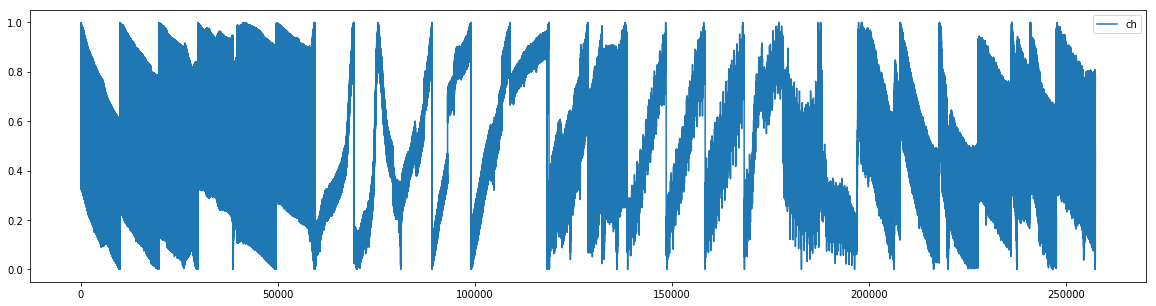

In [39]:
d_plot(r_dat_n, chan=[1])

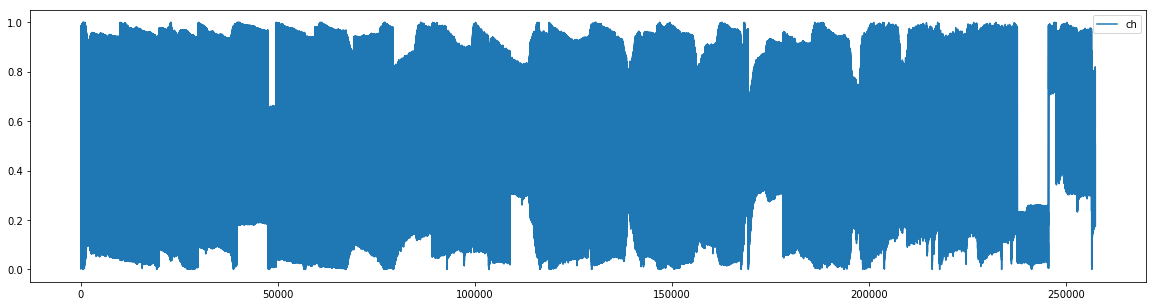

In [40]:
d_plot(w_dat_n, chan=[1])

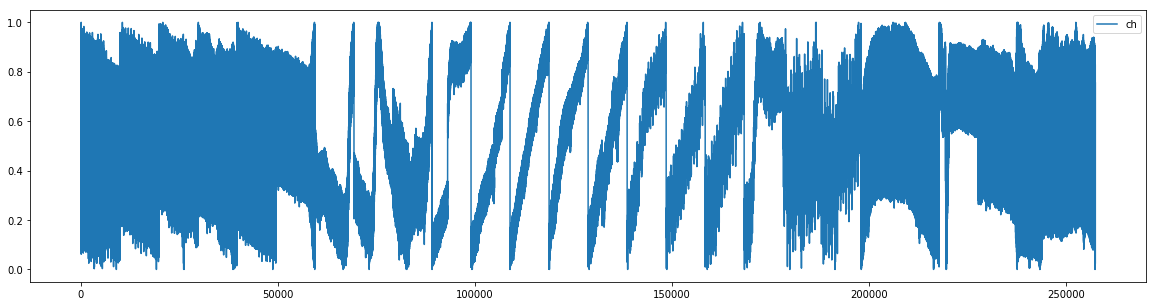

In [41]:
d_plot(r_dat_n, chan=[2])

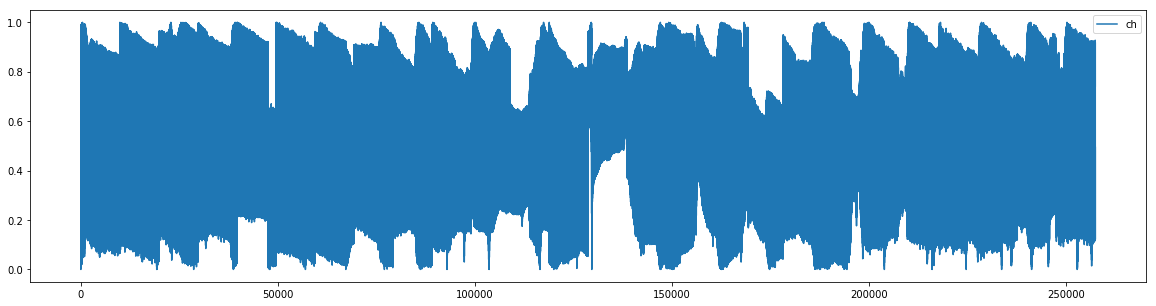

In [42]:
d_plot(w_dat_n, chan=[2])

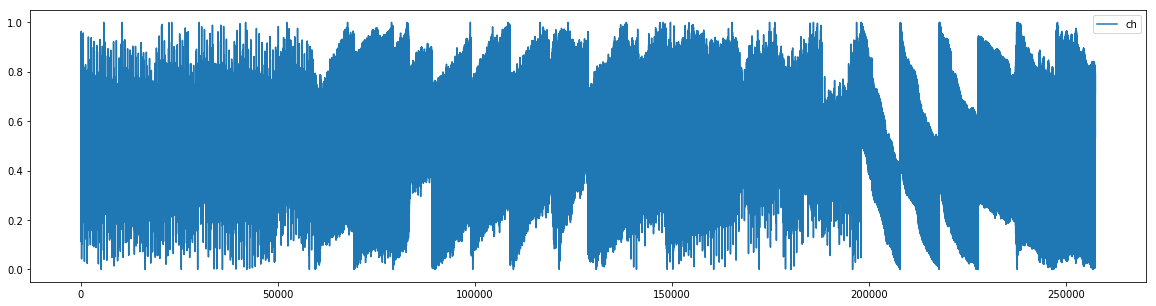

In [43]:
d_plot(r_dat_n, chan=[3])

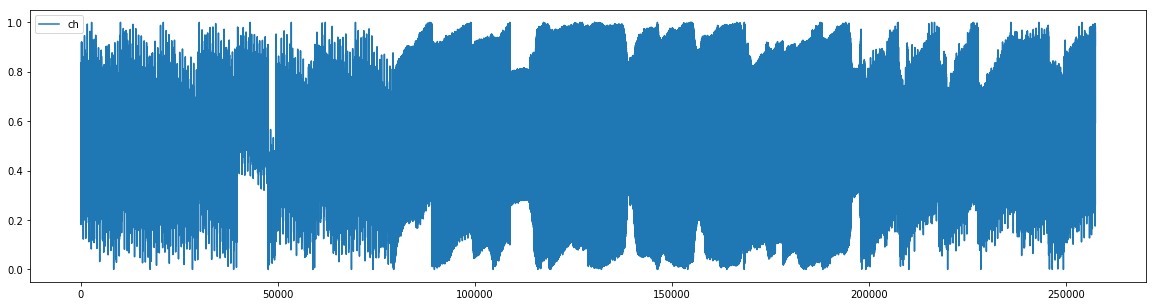

In [44]:
d_plot(w_dat_n, chan=[3])

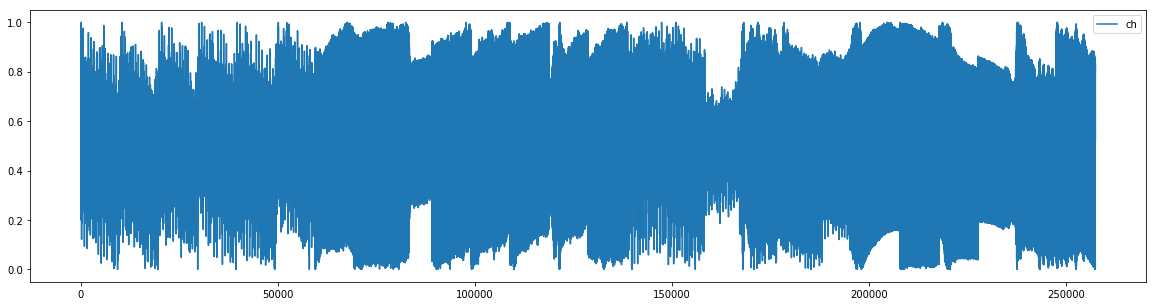

In [45]:
d_plot(r_dat_n, chan=[4])

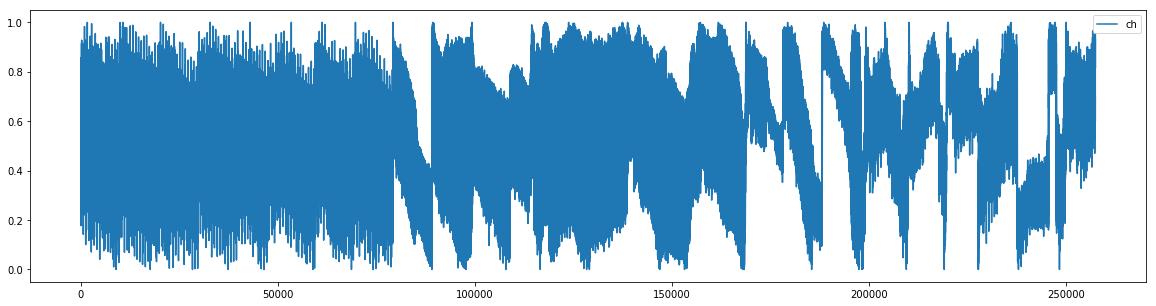

In [46]:
d_plot(w_dat_n, chan=[4])

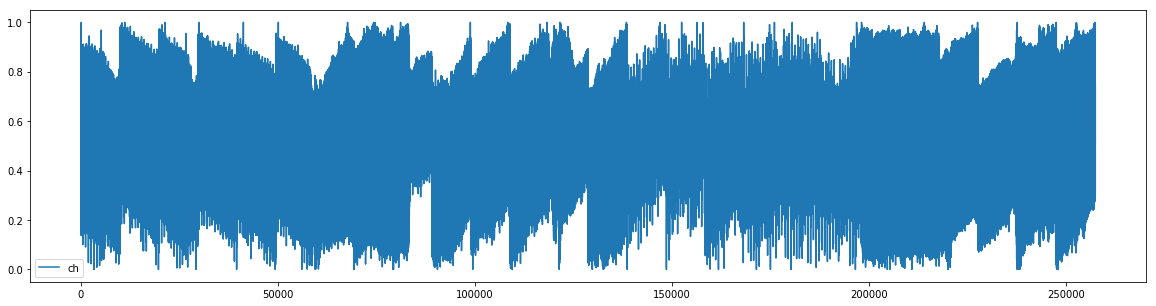

In [47]:
d_plot(r_dat_n, chan=[5])

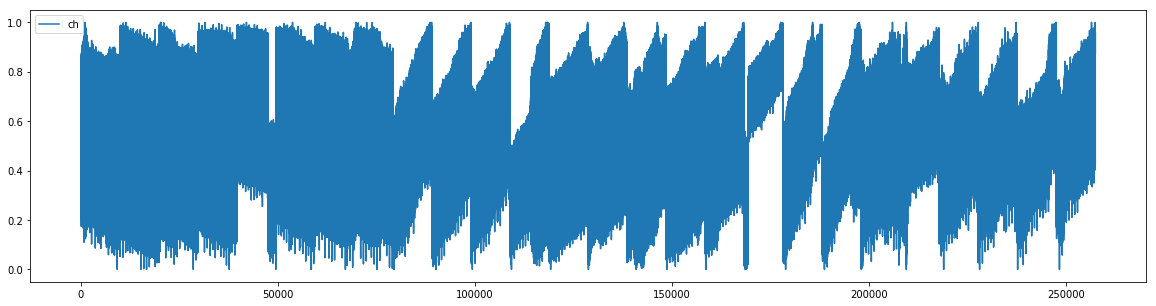

In [48]:
d_plot(w_dat_n, chan=[5])

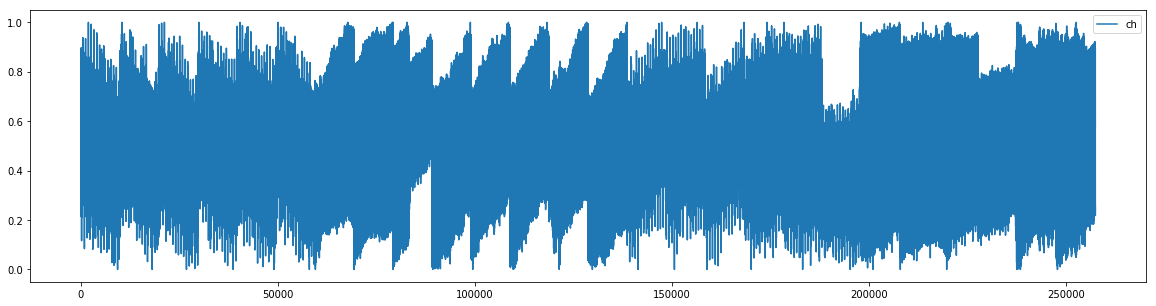

In [49]:
d_plot(r_dat_n, chan=[6])

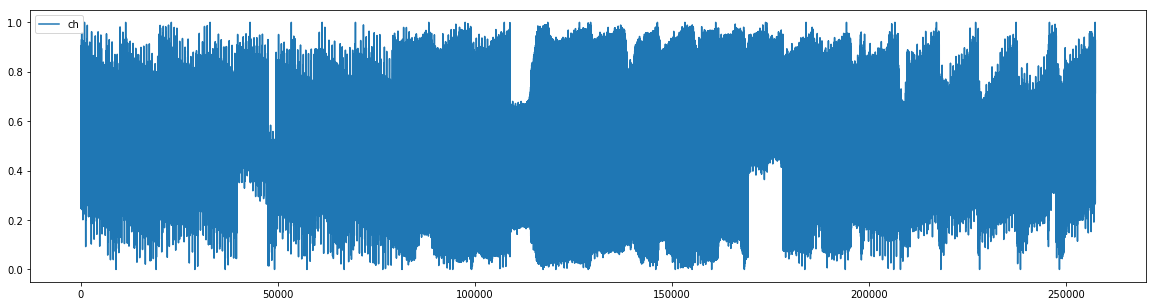

In [50]:
d_plot(w_dat_n, chan=[6])

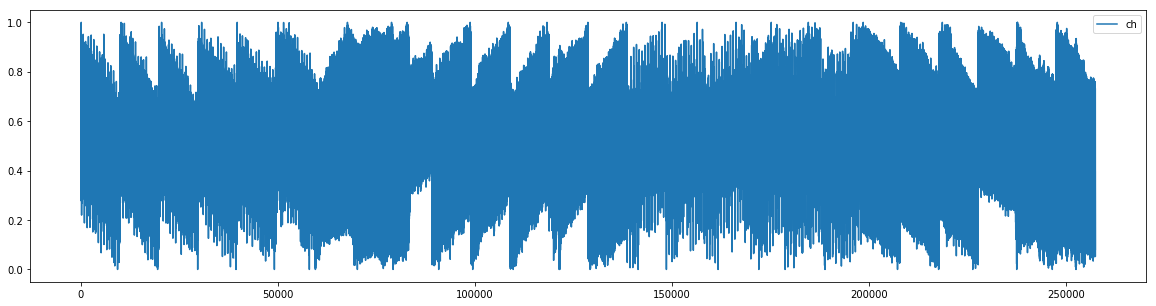

In [51]:
d_plot(r_dat_n, chan=[7])

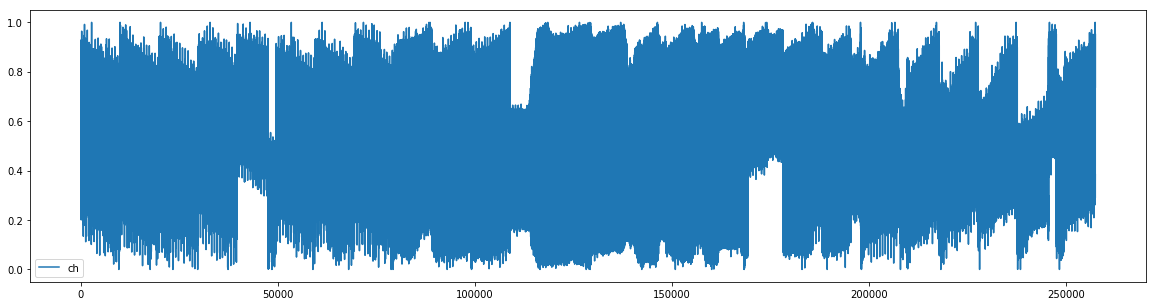

In [52]:
d_plot(w_dat_n, chan=[7])

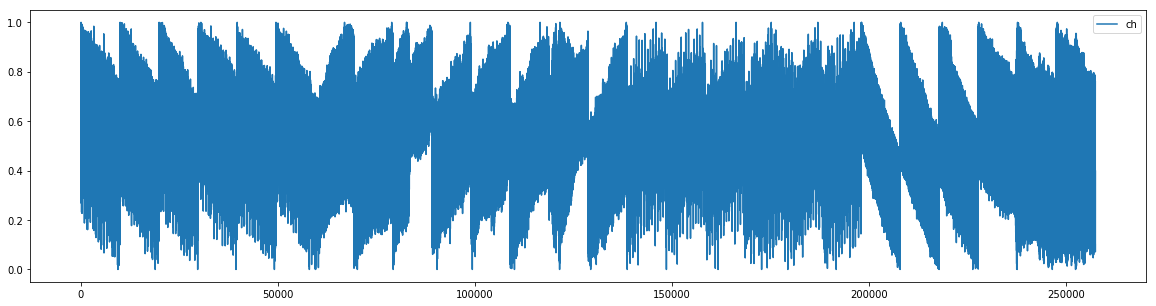

In [53]:
d_plot(r_dat_n, chan=[8])

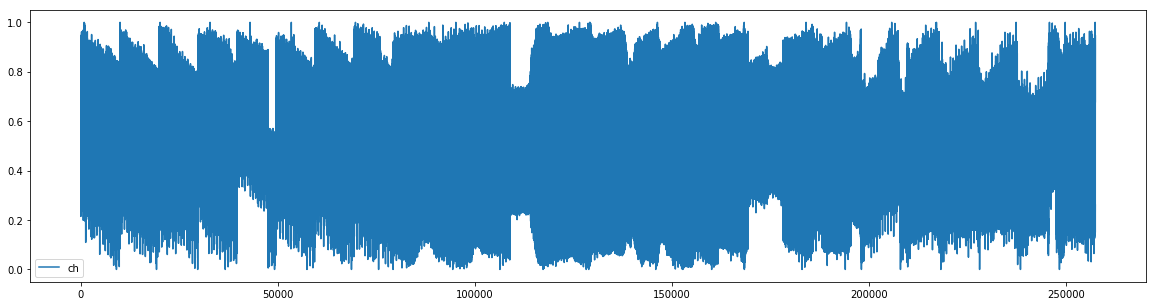

In [54]:
d_plot(w_dat_n, chan=[8])

# Labeling and preparing for Neural Network feeding

<b>making dimensional arrays/data points<b>

There were couple of options explored to exclude some channels which could improve model performance. However it was proved that all channels should contribute to the model.

It was decided to proceed with 1D convolutional model with Keras. For such purpose the matrices of inputs equal to 1 second content should be created. In other words - 1 sample of data represented with matrix that contains 990 rows and 8 columns.

In [55]:
# Full 8 channels conversion
# each second to be converted in one n-dimentional array
def conversion_8(df):
    dat_lst = []
    for s in np.unique(df['sec']):
        dat_lst.append(np.array(df[[1,2,3,4,5,6,7,8]].loc[df['sec'] == s]))
    return np.array(dat_lst, dtype=float)

In [56]:
# 7 channels conversion (3-rd excluded)
# each second to be converted in one n-dimentional array
def conversion_7(df):
    dat_lst = []
    for s in np.unique(df['sec']):
        dat_lst.append(np.array(df[[1,2,4,5,6,7,8]].loc[df['sec'] == s]))
    return np.array(dat_lst, dtype=float)

In [57]:
# 6 channels conversion (no 1-st and 2-nd)
# each second to be converted in one n-dimentional array
def conversion_6(df):
    dat_lst = []
    for s in np.unique(df['sec']):
        dat_lst.append(np.array(df[[3,4,5,6,7,8]].loc[df['sec'] == s]))
    return np.array(dat_lst, dtype=float)

In [58]:
# 4 channels conversion
# each second to be converted in one n-dimentional array
def conversion_4(df):
    dat_lst = []
    for s in np.unique(df['sec']):
        dat_lst.append(np.array(df[[5,6,7,8]].loc[df['sec'] == s]))
    return np.array(dat_lst, dtype=float)

In [59]:
# 2 channels conversion
# each second to be converted in one n-dimentional array
def conversion_2(df):
    dat_lst = []
    for s in np.unique(df['sec']):
        dat_lst.append(np.array(df[[1,2]].loc[df['sec'] == s]))
    return np.array(dat_lst, dtype=float)

In [60]:
r_dat_x = conversion_8(r_dat_n)
w_dat_x = conversion_8(w_dat_n)

In [61]:
r_dat_x.shape

(260, 990, 8)

In [62]:
w_dat_x.shape

(260, 990, 8)

<b>labeling and concatenating<b>

In [63]:
# labels
states = ['reading', 'writing']
labels = [0,1]

In [64]:
# creating output state labels
r_dat_y = np.full([r_dat_x.shape[0],1], labels[0])
w_dat_y = np.full([w_dat_x.shape[0],1], labels[1])

In [65]:
r_dat_y.shape

(260, 1)

In [66]:
w_dat_y.shape

(260, 1)

In [67]:
x_data = np.append(r_dat_x, w_dat_x, axis=0)
y_data = np.append(r_dat_y, w_dat_y, axis=0)
print('x shape:', x_data.shape)
print('y shape:', y_data.shape)

x shape: (520, 990, 8)
y shape: (520, 1)


In [68]:
# here is how one matrix of second looks
x_data[:1]

array([[[ 0.97391336,  0.98772745,  0.35091793, ...,  0.32378344,
          0.44068407,  0.5407581 ],
        [ 0.99238068,  0.93658068,  0.25372903, ...,  0.32772782,
          0.36843397,  0.42929718],
        [ 0.94720656,  0.82643323,  0.28161523, ...,  0.37950731,
          0.37825333,  0.38995522],
        ..., 
        [ 0.75253718,  0.51387081,  0.35772915, ...,  0.45484294,
          0.42299259,  0.3639757 ],
        [ 0.67913761,  0.41029611,  0.45766023, ...,  0.5517329 ,
          0.50146835,  0.39383098],
        [ 0.79764562,  0.6044669 ,  0.35258019, ...,  0.43989836,
          0.41557958,  0.35312953]]])

In [69]:
y_data[:1]

array([[0]])

In [70]:
# One-hot encoding the output
num_classes = len(np.unique(y_data))
y_data = keras.utils.to_categorical(y_data, num_classes=num_classes)
print(y_data.shape)

(520, 2)


In [71]:
y_data[int(len(y_data)/2)-2:int(len(y_data)/2)+2]

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.]], dtype=float32)

<b>preparing datasets for training<b>

In [72]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

print('x_train shape: |', x_train.shape)
print('x_test shape:  |', x_test.shape)
print('y_train shape: |', y_train.shape)
print('y_test shape:  |', y_test.shape)

x_train shape: | (416, 990, 8)
x_test shape:  | (104, 990, 8)
y_train shape: | (416, 2)
y_test shape:  | (104, 2)


## Neural Network Model building & training

In [73]:
# Build the model architecture (worked perfect - 100% accuracy with batch=16 for 8 channels - adjusted with MaxPooling)
model = Sequential()
model.add(Conv1D(32, kernel_size=(3), padding='same',
                 activation='relu',
                 input_shape=(x_train.shape[1], x_train.shape[2],)))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling1D(pool_size=5, padding='same'))
model.add(Conv1D(64, (3), activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling1D(pool_size=3, padding='same'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

Such convolutional 1D Model choice was made due to specifics and volume of data to train on.<br>
Parameters of model were adjusted in course of training. Current parameters are perfect to work with project problem, the only tweakable parameter that need to be altered is training batched. Usually 16 batches are good. However, if there is less data to train the number of batches could be reduced to 8.

In [74]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 990, 32)           800       
_________________________________________________________________
batch_normalization_1 (Batch (None, 990, 32)           3960      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 198, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 196, 64)           6208      
_________________________________________________________________
batch_normalization_2 (Batch (None, 196, 64)           784       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 66, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4224)              0         
__________

In [75]:
# Compile the model using a loss function and an optimizer.
adam = optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

<b>Training the model<b>

In [76]:
# creating checkpoints to grab best results
checkpointer = ModelCheckpoint(filepath='r_w.weights.best.hdf5', verbose=1, 
                               save_best_only=True)

# Train
model.fit(x_train, y_train,
          epochs=25, batch_size=16,
          validation_data=(x_test, y_test), 
          callbacks=[checkpointer], 
          verbose=2, shuffle=True)

Train on 416 samples, validate on 104 samples
Epoch 1/25
 - 4s - loss: 0.4086 - acc: 0.8197 - val_loss: 0.2357 - val_acc: 0.9038

Epoch 00001: val_loss improved from inf to 0.23571, saving model to r_w.weights.best.hdf5
Epoch 2/25
 - 3s - loss: 0.1605 - acc: 0.9279 - val_loss: 0.0958 - val_acc: 0.9712

Epoch 00002: val_loss improved from 0.23571 to 0.09578, saving model to r_w.weights.best.hdf5
Epoch 3/25
 - 3s - loss: 0.1098 - acc: 0.9543 - val_loss: 0.0890 - val_acc: 0.9615

Epoch 00003: val_loss improved from 0.09578 to 0.08899, saving model to r_w.weights.best.hdf5
Epoch 4/25
 - 3s - loss: 0.3462 - acc: 0.8942 - val_loss: 0.0850 - val_acc: 0.9712

Epoch 00004: val_loss improved from 0.08899 to 0.08498, saving model to r_w.weights.best.hdf5
Epoch 5/25
 - 3s - loss: 0.0987 - acc: 0.9567 - val_loss: 0.2656 - val_acc: 0.8846

Epoch 00005: val_loss did not improve from 0.08498
Epoch 6/25
 - 3s - loss: 0.0661 - acc: 0.9736 - val_loss: 0.0402 - val_acc: 0.9904

Epoch 00006: val_loss impro

<b>Load the Model with the Best Classification Accuracy<b>

In [77]:
# load the weights that yielded the best validation accuracy
# model.load_weights('r_w.weights.best.hdf5')

<b>Evaluate the model<b>

In [78]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: ", score[1])

Accuracy:  1.0


### Testing prediction

We can see that Model accuracy is perfect, but lets test it and use separate dataset generate apart of those created for training and validation.

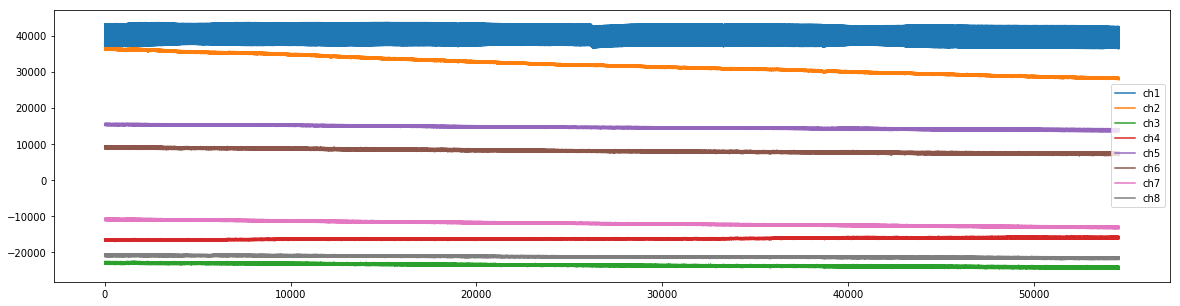

In [79]:
# previewing reading test (independent data gathered)
data = pd.read_csv(path+'OpenBCI-RAW-reading_t.txt', sep=",", header=None)
d_plot(data)

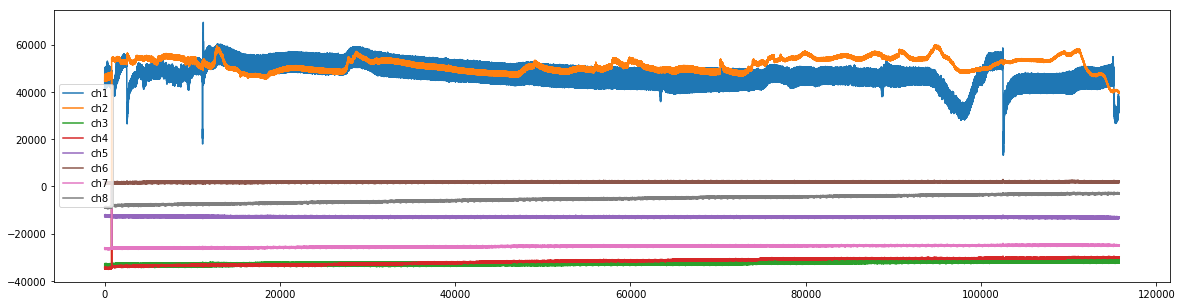

In [80]:
# previewing reading test (independent data gathered)
data = pd.read_csv(path+'OpenBCI-RAW-writing_t.txt', sep=",", header=None)
d_plot(data)

In [81]:
# preprocessing
read_test = preprocess(path + 'OpenBCI-RAW-reading_t.txt', dur=dur, var=margin, secbatch=secbatch)

(54589, 9)
Realigned time column

Seconds in dataset now:  55
Cleaned spikes larger than 15000

Seconds in dataset now:  55
Check completed for balanced intervals!

Seconds in dataset now:  50
Check completed for balanced intervals!
Dataset has been rescaled 



In [82]:
# preprocessing
write_test = preprocess(path + 'OpenBCI-RAW-writing_t.txt', dur=dur, var=margin, secbatch=secbatch)

(115770, 9)
Realigned time column

Seconds in dataset now:  118
Cleaned spikes larger than 15000

Seconds in dataset now:  109
Check completed for balanced intervals!

Seconds in dataset now:  100
Check completed for balanced intervals!
Dataset has been rescaled 



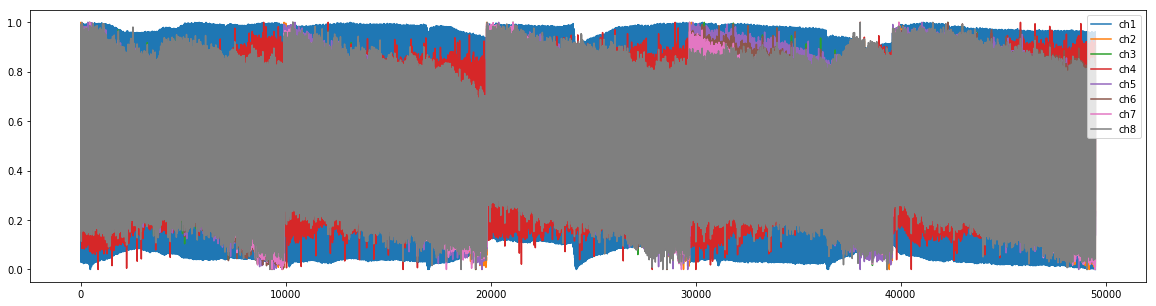

In [83]:
d_plot(read_test)

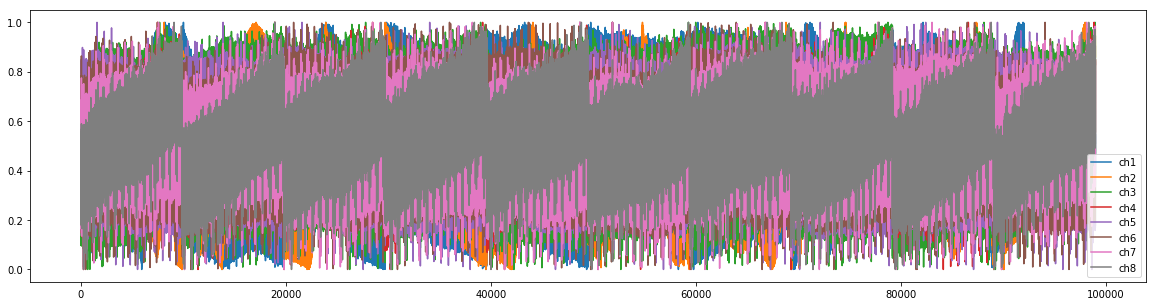

In [84]:
d_plot(write_test)

In [85]:
r_dat_xt = conversion_8(read_test)
w_dat_xt = conversion_8(write_test)

In [86]:
# predict any class
def predict_all(data, st):
    '''takes data - array with tensors for prediction
    predict any state depending on labels match '''
    timer = []
    sec = 0
    count_state = []
    for i in data:
        sec += 1
        count_all = timer.append(sec)
        if model.predict(np.array([i]))[0][0] > 0.5:
            count_state.append(0)
            #print('Second {}: {}'.format(sec, states[0]))
        elif model.predict(np.array([i]))[0][1] > 0.5:
            count_state.append(1)
            #print('Second {}: {}'.format(sec, states[1]))
        else:
            count_state.append(2)
            #print('Second {}: {}'.format('Unknown'))
                  
    read_count = np.count_nonzero(np.array(count_state) == 0)
    write_count = np.count_nonzero(np.array(count_state) == 1)
    unknown_count = np.count_nonzero(np.array(count_state) == 2)

    if st == 'r':
        print('\nPredicted reading: {} sec | unknown: {} sec | from total {} sec of READING set'.format(read_count,
                                                                                                     unknown_count,
                                                                                             len(count_state)))
        print('Prediction accuracy for READING on new environment dataset is: {}%'.format(int(read_count/len(count_state)*100)))
        st_int_r = 1
        st_int_w = 0
    elif st == 'w':
        print('\nPredicted writing: {} sec | unknown: {} sec | from total {} sec of WRITING set'.format(write_count,
                                                                                                     unknown_count,
                                                                                             len(count_state)))
        print('Prediction accuracy for WRITING on new environment dataset is: {}%'.format(int(write_count/len(count_state)*100)))
        st_int_r = 0
        st_int_w = 1
    return {st_int_r: int(read_count/len(count_state)*100), st_int_w: int(write_count/len(count_state)*100)}

In [87]:
benchmark = [predict_all(r_dat_xt, 'r'), predict_all(w_dat_xt, 'w')]
acc = []
for b in benchmark:
    acc.append(b[1])
print('\nReal model accuracy is: {}%'.format(np.average([acc])))


Predicted reading: 46 sec | unknown: 0 sec | from total 50 sec of READING set
Prediction accuracy for READING on new environment dataset is: 92%

Predicted writing: 62 sec | unknown: 0 sec | from total 100 sec of WRITING set
Prediction accuracy for WRITING on new environment dataset is: 62%

Real model accuracy is: 77.0%
